# Using LLMs as Generalist Text Embedding Models - NVEmbed Model Review 

Code for the blog post on using LLMs as generalist text embedding models. 

We will explore the NV-Embed model,  a generalist embedding model based on Mistral 7B

Note: the model requires a [specific version](https://huggingface.co/nvidia/NV-Embed-v2#2-required-packages) of the transformers library.

```bash 
pip uninstall -y transformer-engine
pip install torch==2.2.0
pip install transformers==4.42.4
pip install flash-attn==2.2.0
pip install sentence-transformers==2.7.0

```

In [1]:
# !pip install seaborn

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gc
import os
from tqdm import tqdm
import pandas as pd
import altair as alt


# Set PyTorch to use expandable segments to avoid fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# note, you will need to have a GPU to run this code
def load_model(model_name='nvidia/NV-Embed-v2'):
    return AutoModel.from_pretrained(model_name, trust_remote_code=True, device_map="auto")

model = load_model()

/home/victordibia/miniconda3/envs/autohf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/victordibia/miniconda3/envs/autohf/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/nvidia/NV-Embed-v2:
- configuration_nvembed.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/NV-Embed-v2:
- modeling_nvembed.py
. Make sure to double-check they do not contain any added malicious code. To avoid dow

In [3]:
def get_embeddings(model, texts, instruction, max_length=32768, batch_size=150):
    """
    Get embeddings for a list of texts with a specific instruction.
    Modify batch_size based on your GPU memory.
    """
    prefix = f"Instruct: {instruction}\nQuery: " if instruction else ""
    
    if len(texts) <= batch_size:
        embeddings = model.encode(texts, instruction=prefix, max_length=max_length, truncation=True)
        return F.normalize(embeddings, p=2, dim=1)
    
    # Process in batches
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        # Clear GPU cache before each batch
        # if torch.cuda.is_available():
        #     torch.cuda.empty_cache()
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch_texts, instruction=prefix, max_length=max_length)
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all batches
    embeddings = torch.cat(all_embeddings, dim=0)
    return F.normalize(embeddings, p=2, dim=1)

def get_scores(embeddings1, embeddings2):
    """
    Calculate similarity scores between two sets of embeddings.
    Ensures that both sets of embeddings have the same dimensions.
    """
    if embeddings1.shape[1] != embeddings2.shape[1]:
        raise ValueError("Embedding dimensions do not match. Please ensure both sets of embeddings have the same dimensionality.")
    return (embeddings1 @ embeddings2.T) * 100

def reduce_dimensions(embeddings, n_components=2, method='tsne'):
    """
    Reduce dimensions of embeddings using t-SNE (default) or PCA.
    
    Args:
    embeddings: Input embeddings (numpy array or torch.Tensor)
    n_components: Number of components in reduced space (default: 2)
    method: Reduction method, either 'tsne' or 'pca' (default: 'tsne')
    
    Returns:
    Reduced embeddings as a numpy array
    """
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()
    
    if n_components and n_components < embeddings.shape[1]:
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42)
        elif method.lower() == 'pca':
            reducer = PCA(n_components=n_components)
        else:
            raise ValueError("Method must be either 'tsne' or 'pca'")
        
        return reducer.fit_transform(embeddings)
    return embeddings

def process_embeddings(model, texts, instruction, task_type, n_components=None):
    """
    Process embeddings based on the task type (e.g., clustering, classification).
    Optionally reduce dimensions if n_components is specified.
    """
    embeddings = get_embeddings(model, texts, instruction) 
    
    embeddings = reduce_dimensions(embeddings, n_components)
    
    if task_type == "clustering":
        # For clustering, we might want to keep the reduced dimensions
        return embeddings
    
    elif task_type == "classification":
        # For classification, we might want to use the full embeddings
        return embeddings
    
    else:
        return embeddings

def flush_memory():
    """
    Flush GPU memory and run garbage collection.
    """
    torch.cuda.empty_cache()
    gc.collect()

In [4]:
import pandas as pd
df = pd.read_json('yc_data.json')
df["one_liner"] = df.one_liner.fillna("").astype(str)
df["long_description"] = df.long_description.fillna("").astype(str)
df["desc"] = df.one_liner + " " + df.long_description 
df["short"] = df.name + " \n " + df.one_liner

original_length = len(df) 
df = df[df['desc'].notna() & (df['desc'].str.len() >= 5)] 
rows_dropped = original_length - len(df)

print(f"Dropped {rows_dropped} rows where 'desc' was NaN or had length less than 5.")
print(f"New DataFrame length: {len(df)}")


def mentions_ai_agents(text):
    text = text.lower()
    return ((" ai " in text or "artificial intelligence" in text or "machine learning" in text or "llm" in text  or "nlp" in text ) and "agent" in text)

def mentions_ai(text):
    text = text.lower()
    return (" ai " in text or "artificial intelligence" in text or "llm" in text  or "nlp" in text or "machine learning" in text)

df["mentions_ai_agents"] = df.desc.apply(mentions_ai_agents)
df["mentions_ai"] = df.desc.apply(mentions_ai)
df.head(3)

Dropped 0 rows where 'desc' was NaN or had length less than 5.
New DataFrame length: 4491


,id,name,slug,former_names,small_logo_thumb_url,website,all_locations,long_description,one_liner,team_size,...,app_answers,question_answers,objectID,_highlightResult,new_tags,desc,short,mentions_ai_agents,mentions_ai,oai_embedding
0,29774,Mineflow,mineflow,[],https://bookface-images.s3.amazonaws.com/small...,http://mineflow.ai/,"San Francisco, CA, USA",Mineflow is an AI platform for mineral explora...,Mineflow predicts the shape and location of mi...,1.0,...,1.0,True,29774,"{'name': {'value': 'Mineflow', 'matchLevel': '...","[mining, AI, industrial]",Mineflow predicts the shape and location of mi...,Mineflow \n Mineflow predicts the shape and lo...,False,True,"[-0.017166310900000002, -0.025343457200000002,..."
1,29655,Decisional AI,decisional-ai,[],https://bookface-images.s3.amazonaws.com/small...,https://www.getdecisional.ai/,"San Francisco, CA, USA",Decisional is building an AI Financial Analyst...,AI Agent for Financial Analysts,3.0,...,NaN,False,29655,"{'name': {'value': 'Decisional AI', 'matchLeve...","[fintech, SaaS, finance, B2B, AI]",AI Agent for Financial Analysts Decisional is ...,Decisional AI \n AI Agent for Financial Analysts,True,True,"[0.0033661788000000003, -0.0020344472, 0.00351..."
2,29739,Planbase,planbase,[],https://bookface-images.s3.amazonaws.com/small...,https://www.joinplanbase.com/,"San Francisco, CA, USA",Planbase has everything modern clinics need to...,Workforce management for modern healthcare,2.0,...,NaN,False,29739,"{'name': {'value': 'Planbase', 'matchLevel': '...","[SaaS, health, productivity, AI]",Workforce management for modern healthcare Pl...,Planbase \n Workforce management for modern he...,False,False,"[-0.0338573568, 0.032673534000000004, 0.090812..."


Text(0.5, 1.0, 'YC Companies by Launch Date (Mentions of AI Agents)')

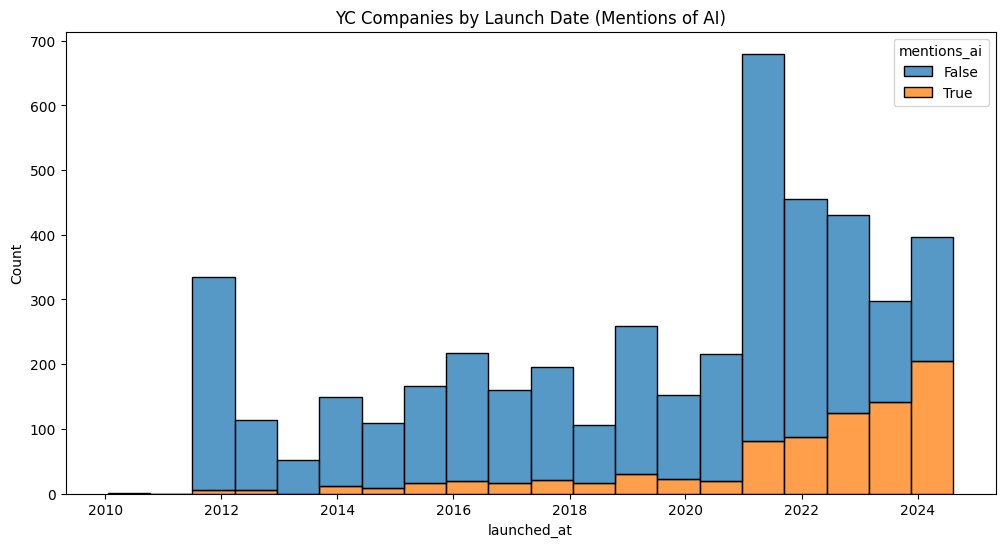

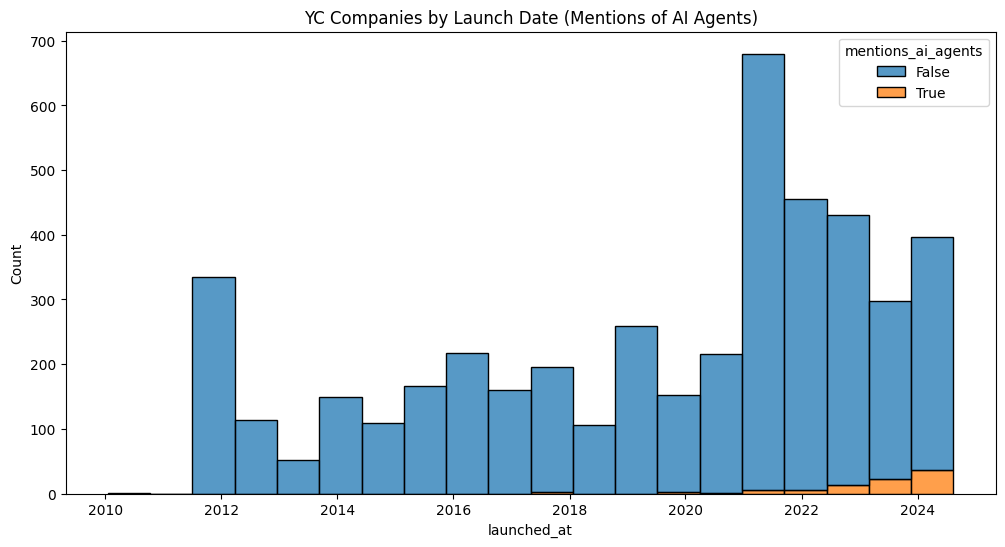

In [5]:
# sns plot of companies by launched_at colored by whether they mention AI

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(df, x="launched_at", hue="mentions_ai", multiple="stack", bins=20); 
plt.title("YC Companies by Launch Date (Mentions of AI)")

plt.figure(figsize=(12, 6))
sns.histplot(df, x="launched_at", hue="mentions_ai_agents", multiple="stack", bins=20);
plt.title("YC Companies by Launch Date (Mentions of AI Agents)")

In [20]:
import pandas as pd
import altair as alt

def plot_clusters(reduced_dims, mdf, color_by='mentions_ai', title=None, tooltip_cols=None):
    if tooltip_cols is None:
        tooltip_cols = ["name", "desc", "launched_at", "industry"]
    # Ensure mdf has the same number of rows as reduced_dims
    if len(reduced_dims) != len(mdf):
        print(f"Warning: reduced_dims ({len(reduced_dims)} rows) and mdf ({len(mdf)} rows) have different sizes.")
        print("Subsetting mdf to match reduced_dims size.")
        mdf = mdf.iloc[:len(reduced_dims)].copy()

    df = pd.DataFrame(reduced_dims, columns=["x", "y"])
    
    # Dynamically add all columns from mdf to df
    for col in mdf.columns:
        df[col] = mdf[col].values

    # Ensure the color_by column exists
    if color_by not in df.columns:
        raise ValueError(f"The column '{color_by}' is not present in the dataframe.")

    # Determine color scale based on the data type of the color_by column
    if df[color_by].dtype == 'bool':
        color_scale = alt.Scale(domain=[True, False], range=["#1f77b4", "#ff7f0e"])
    elif df[color_by].dtype == 'object' or df[color_by].dtype.name == 'category':
        color_scale = alt.Scale(scheme='category10')
    else:  # Assuming numerical data for any other type
        color_scale = alt.Scale(scheme='viridis')

    chart = alt.Chart(df).mark_circle(size=60).encode(
        x="x",
        y="y",
        color=alt.Color(f"{color_by}:N", 
                        scale=color_scale,
                        legend=alt.Legend(title=color_by.replace('_', ' ').title())),
        tooltip=tooltip_cols
    ).properties(
        width=600,
        height=300,
        title=title
    ).interactive()
    
    return chart

In [21]:
max_seq_length=1500
flush_memory()
num_samples = 500
yc_desc = df.desc.tolist()[0:num_samples]

semantic_clustering_instruction = "Given a company description, retrieve other companies that are semantically similar or are in the same domain." 
seantic_clustering_embeddings =  get_embeddings(model, yc_desc, semantic_clustering_instruction, max_length=max_seq_length )

semantic_reduced_dims = reduce_dimensions(seantic_clustering_embeddings, 2)  

plot_clusters(semantic_reduced_dims, df, color_by='mentions_ai', title="Semantic Instruction Clustering of YC Companies")

Processing batches:   0%|          | 0/5 [00:00<?, ?it/s]/mnt/data2/cache/transformers/modules/transformers_modules/nvidia/NV-Embed-v2/0783263f3c009f67bd0e177040cfecad4b1171d6/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
Processing batches:  20%|██        | 1/5 [00:00<00:02,  1.39it/s]

In [8]:
flush_memory() 
base_embeddings =  get_embeddings(model, yc_desc, "", max_length=max_seq_length ) 
base_reduced_dims = reduce_dimensions(base_embeddings, 2)                   
plot_clusters(base_reduced_dims, df, color_by='mentions_ai', title="Clustering of YC Companies")

Processing batches:   0%|          | 0/10 [00:00<?, ?it/s]/mnt/data2/cache/transformers/modules/transformers_modules/nvidia/NV-Embed-v2/0783263f3c009f67bd0e177040cfecad4b1171d6/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
Processing batches: 100%|██████████| 10/10 [01:15<00:00,  7.57s/it]


alt.Chart(...)

In [9]:
flush_memory()
ai_clustering_instruction = "Given a company description, retrieve companies that are using Artificial Intelligence (AI) for tasks. \nQuery" 
ai_clustering_embeddings =  get_embeddings(model, yc_desc, ai_clustering_instruction, max_length=max_seq_length)

ai_reduced_dims = reduce_dimensions(ai_clustering_embeddings, 2)  
plot_clusters(ai_reduced_dims, df , color_by='mentions_ai', title="AI Instruction Clustering of YC Companies")

Processing batches:   0%|          | 0/10 [00:00<?, ?it/s]/mnt/data2/cache/transformers/modules/transformers_modules/nvidia/NV-Embed-v2/0783263f3c009f67bd0e177040cfecad4b1171d6/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
Processing batches: 100%|██████████| 10/10 [01:21<00:00,  8.13s/it]


alt.Chart(...)

In [10]:
tokens = model.tokenizer(df.desc.tolist(), truncation=True, padding=True,   return_tensors="pt")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [11]:
# print max and min token length 
# 
print(max([len(token) for token in tokens['input_ids']]))  
print(min([len(token) for token in tokens['input_ids']]))


1169
1169


In [12]:
df.shape

(4491, 38)